In [529]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cdsapi as cds #Climate Data Store API
from sklearn.linear_model import LinearRegression

In [516]:
# load data
ds = xr.load_dataset("uv10_webb.nc")

NetCD file of u10 and v10 winds from 1 Jan 1979 to 31 Dec 2021. Time is hourly. 

**Location**
Bounding box coords in DD:
56.91667 N, 61.333 E
56.5166 S, 62.2206 W

In [517]:
ds

<xarray.Dataset>
Dimensions:    (time: 376944, latitude: 3, longitude: 6)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 ... 2021-12-31T23:00:00
  * longitude  (longitude) float32 297.8 298.0 298.2 298.5 298.8 299.0
  * latitude   (latitude) float32 57.0 56.75 56.5
Data variables:
    u10        (time, latitude, longitude) float32 0.9306 0.7573 ... 4.556 4.821
    v10        (time, latitude, longitude) float32 1.007 1.193 ... -1.463 -1.986
Attributes:
    Conventions:  CF-1.6
    history:      2019-03-15 17:03:15 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

In [518]:
# calculate wind speed 

ds["speed"] = np.sqrt(np.square(ds.u10) + np.square(ds.v10))    
ds.speed.attrs["units"] = "meter_second"
ds.speed.interpolate_na(dim='time')

<xarray.DataArray 'speed' (time: 376944, latitude: 3, longitude: 6)>
array([[[1.3715166, 1.4129531, 2.2308779, 2.8053734, 4.0005784,
         4.8996553],
        [1.1093988, 1.2327856, 1.6552318, 2.4234161, 3.4827502,
         4.3712273],
        [1.3238641, 1.2114818, 1.5582576, 2.2798657, 3.094349 ,
         3.62578  ]],

       [[1.3706226, 1.4652396, 2.3503406, 2.990419 , 4.3471284,
         5.361595 ],
        [1.2028624, 1.3313354, 1.7750647, 2.6298282, 3.8089483,
         4.79166  ],
        [1.3680055, 1.4098364, 1.7459722, 2.492584 , 3.3959835,
         3.9831252]],

       [[1.6143486, 1.7750093, 2.6161828, 3.049133 , 4.428123 ,
         5.485295 ],
        [1.4392028, 1.5974228, 1.8537778, 2.6022098, 3.7833762,
         4.8181915],
        [1.4417428, 1.6012354, 1.7471954, 2.3779469, 3.2835503,
         3.9340465]],
...
       [[2.450177 , 2.1915216, 3.383241 , 3.3633587, 4.6221066,
         5.7455   ],
        [2.1640298, 2.4465144, 2.6931407, 3.0562124, 4.0161285,
         4.795918 ],
        [2.7713945, 2.8705149, 3.4653366, 4.4318495, 5.133039 ,
         5.6309414]],

       [[2.4030957, 2.1115522, 3.2809663, 3.2761376, 4.4990926,
         5.600546 ],
        [2.1092832, 2.2893717, 2.4737027, 2.9047854, 3.923885 ,
         4.667829 ],
        [2.6100807, 2.7066765, 3.2257953, 4.2471657, 5.0237107,
         5.4775047]],

       [[2.396147 , 2.05589  , 3.1206012, 3.1018507, 4.2159266,
         5.2492642],
        [2.1107044, 2.2428222, 2.4634535, 2.8366292, 3.7496123,
         4.4298925],
        [2.46934  , 2.594646 , 3.146504 , 4.092299 , 4.785289 ,
         5.2142587]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 ... 2021-12-31T23:00:00
  * longitude  (longitude) float32 297.8 298.0 298.2 298.5 298.8 299.0
  * latitude   (latitude) float32 57.0 56.75 56.5
Attributes:
    units:    meter_second

In [519]:
# calculate wind direction

ds["direction"] =  270 - (np.arctan2(ds.v10,ds.u10)*(180/np.pi))
ds.direction.attrs["units"] = "degrees"

In [520]:
ds.to_netcdf('WebbBay_winds_historic.nc')

Working with a single point from the data for analysis. How to work with the full dataset? 

In [521]:
ds1d = ds.loc[dict(latitude=56.75, longitude=298.25)]
ds1d

<xarray.Dataset>
Dimensions:    (time: 376944)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 ... 2021-12-31T23:00:00
    longitude  float32 298.2
    latitude   float32 56.75
Data variables:
    u10        (time) float32 0.7589 0.7262 0.772 0.6444 ... 2.615 2.42 2.416
    v10        (time) float32 1.471 1.62 1.685 1.589 ... -0.6438 -0.5106 -0.4835
    speed      (time) float32 1.655 1.775 1.854 1.715 ... 2.693 2.474 2.463
    direction  (time) float32 207.3 204.1 204.6 202.1 ... 283.8 281.9 281.3
Attributes:
    Conventions:  CF-1.6
    history:      2019-03-15 17:03:15 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

In [522]:
monthly_avg = ds1d.resample(time="1MS").mean()

# function resamples timeseries data in xarray 
# returns an average monthly value MS = month start (for labeling)

In [523]:
# create a pandas dataframe of wind speed values
# pd dfs support double reindexing but xarray will only reindex once

ws = monthly_avg["speed"].reset_coords(drop=True).to_dataframe()

# add year and month indices
ws['month']=ws.index.month
ws['year']=ws.index.year

# groupby month and year and mean
ws = ws.groupby(['year','month']).mean().unstack().T.droplevel(0)

# groupby function creates groupby object
# mean, unstack, transpose, and drop level  stack rows 
# ref https://stackoverflow.com/questions/64319937/plot-monthly-average-over-multiple-years-with-xarray

In [524]:
ws.tail()

year,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
month,,,,,,,,,,,,,,,,,,,,,
8,3.065351,2.388775,2.446871,3.151660,2.986007,3.586902,2.490277,2.906412,2.393810,3.421101,...,2.433766,3.068559,2.441374,2.436682,2.888393,2.796335,3.310210,2.682798,2.943310,2.934356
9,3.550292,3.375842,3.090459,3.453278,2.912166,3.648361,3.096469,3.310478,2.736493,3.230441,...,3.742556,3.329018,3.869142,3.389803,3.087956,2.966128,4.273786,3.475225,3.673309,3.342726
10,3.387074,3.328518,3.650434,3.229544,3.380734,3.270505,2.900905,4.290392,3.253022,3.148561,...,3.477500,2.797595,3.163879,3.667784,3.471363,3.572537,4.064254,3.302896,3.700752,2.755181
11,3.247052,3.077521,3.585228,3.559854,3.596364,4.043325,3.263813,3.468104,3.606544,4.244339,...,3.837692,3.664670,3.760815,3.368504,3.103598,4.071574,3.425825,3.882993,3.586662,3.223992
12,3.439133,3.818065,3.335263,3.449428,3.693297,3.946279,4.215046,3.061650,3.354362,3.153701,...,3.288066,4.239893,3.708031,3.881188,3.372180,4.014212,3.713704,3.587046,3.362190,4.075172


## Wind speeds over the 12 months of a year:

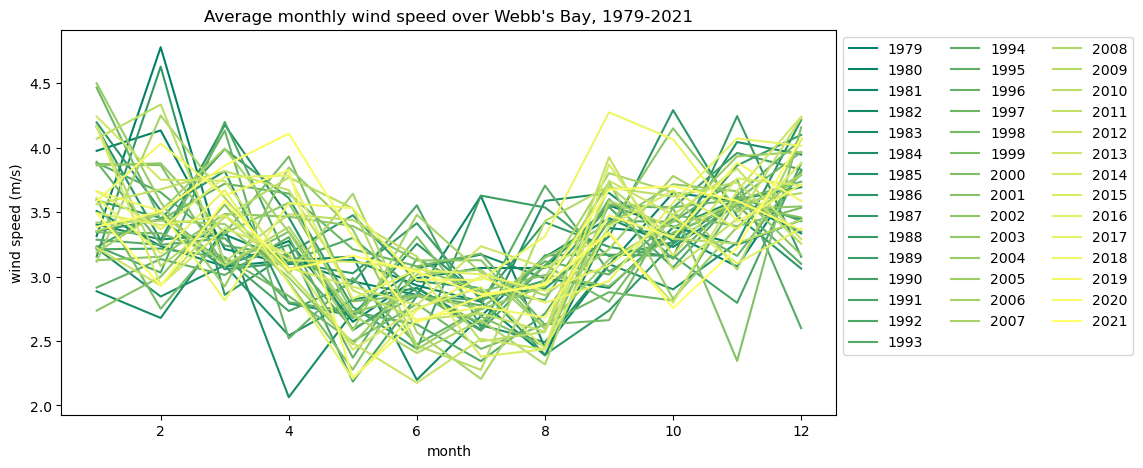

In [525]:
# Visualize the wind speed time series

ws.plot(figsize=(10,5), cmap="summer", ylabel="wind speed (m/s)",
       title="Average monthly wind speed over Webb's Bay, 1979-2021")

plt.legend(ncol=3, bbox_to_anchor=[1,1])
plt.savefig('Monthly wind speeds 1979 to 2021.png', bbox_inches='tight')
plt.show()

Not a statistical or rigorous look at the data but there doesn't seem to be very significant trend in the data over time. Definitely see the seasonal variation, with highest winds in the late fall and winter months and a low over the summer. 

## Wind speeds over time (avg, max, min):

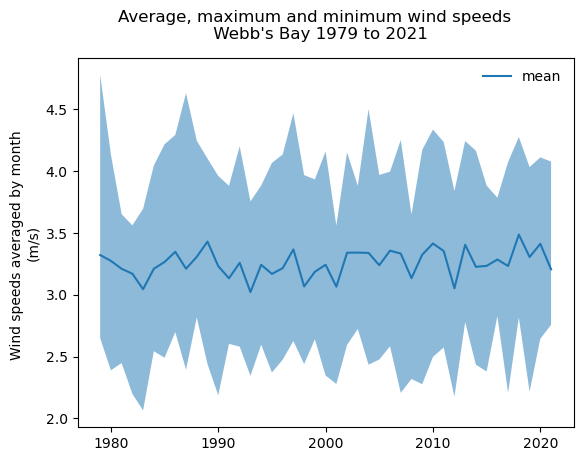

In [526]:
x = np.linspace(1979, 2021, 43) # yearly timeseries for plotting
y1 = ws.max() 
y2 = ws.min()

# plot
fig, ax = plt.subplots()

ax.plot(x, ws.mean(), label="mean")
ax.fill_between(x, y1, y2, alpha=.5, linewidth=0)
ax.set_ylabel("Wind speeds averaged by month \n(m/s)")
ax.legend(frameon=False)
fig.suptitle("Average, maximum and minimum wind speeds \n Webb's Bay 1979 to 2021")

plt.show()

## Seasonal breakdown:

In [632]:
fall = ws.iloc[8:12, :] # September to December inclusive
fall

year,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
month,,,,,,,,,,,,,,,,,,,,,
9,3.550292,3.375842,3.090459,3.453278,2.912166,3.648361,3.096469,3.310478,2.736493,3.230441,...,3.742556,3.329018,3.869142,3.389803,3.087956,2.966128,4.273786,3.475225,3.673309,3.342726
10,3.387074,3.328518,3.650434,3.229544,3.380734,3.270505,2.900905,4.290392,3.253022,3.148561,...,3.477500,2.797595,3.163879,3.667784,3.471363,3.572537,4.064254,3.302896,3.700752,2.755181
11,3.247052,3.077521,3.585228,3.559854,3.596364,4.043325,3.263813,3.468104,3.606544,4.244339,...,3.837692,3.664670,3.760815,3.368504,3.103598,4.071574,3.425825,3.882993,3.586662,3.223992
12,3.439133,3.818065,3.335263,3.449428,3.693297,3.946279,4.215046,3.061650,3.354362,3.153701,...,3.288066,4.239893,3.708031,3.881188,3.372180,4.014212,3.713704,3.587046,3.362190,4.075172


In [633]:
model = LinearRegression()

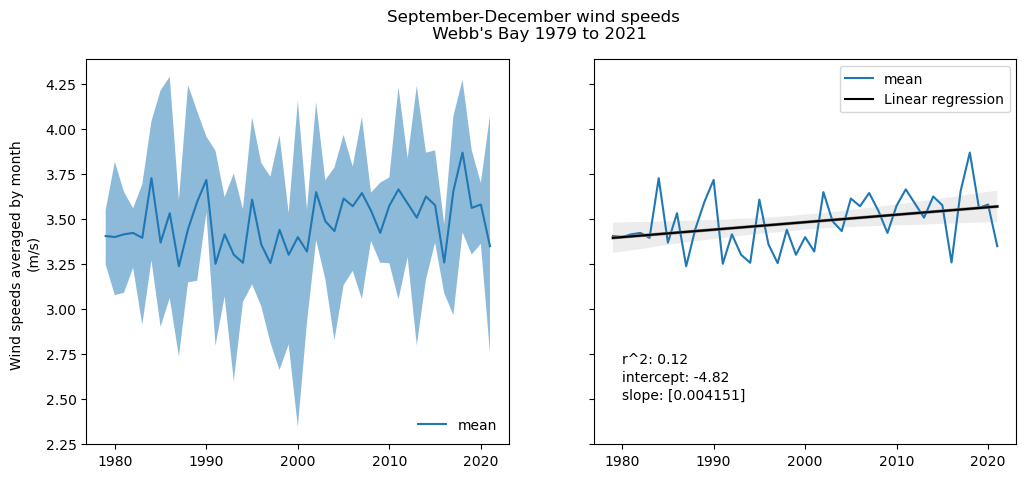

In [639]:
x = np.linspace(1979, 2021, 43)
y = fall.mean()
y1 = fall.max()
y2 = fall.min()

# plot
fig, (ax, ax2) = plt.subplots(1,2, figsize=(12,5), sharey=True)

ax.plot(x, y, label="mean")
ax.fill_between(x, y1, y2, alpha=.5, linewidth=0)
ax.set_ylabel("Wind speeds averaged by month \n(m/s)")
ax.legend(frameon=False, loc="lower right")

# 2nd plot showing trendline for mean data
ax2.plot(x, y, label="mean")
sns.regplot(x=x, y=y, marker='', color='grey')
fig.suptitle("September-December wind speeds \n Webb's Bay 1979 to 2021")

# linear regression
x = x.reshape((-1,1)) # reshape array
y = y.to_numpy() # change pd series to numpy array

new_model = LinearRegression().fit(x, y) 
r_sq = new_model.score(x, y) # calculate coefficient of determination
y_pred = new_model.intercept_ + new_model.coef_ * x # predicted y values

# add text to figure
ax2.text(x=1980, y=2.7, s=f"r^2: {r_sq:0.2}")
ax2.text(x=1980, y=2.6, s= f"intercept: {new_model.intercept_:0.3}")
ax2.text(x=1980, y=2.5, s=f"slope: {new_model.coef_}")

# plot model fit
ax2.plot(x, y_pred, color='black', label='Linear regression')

ax2.legend()

plt.show()

September - December timeframe shows a more convincing increase over time.

In [640]:
winter = ws.iloc[0:4, :] # January to April inclusive
winter

year,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
month,,,,,,,,,,,,,,,,,,,,,
1,3.313513,3.975210,3.508147,3.403024,2.885983,3.219682,4.159583,4.195702,3.155681,3.591571,...,3.222568,4.241603,4.162868,3.492629,3.662413,3.613091,3.660902,3.584800,3.385540,3.490685
2,4.778954,4.133557,3.236134,3.287654,2.678703,2.845181,3.282373,3.512834,4.628026,3.454734,...,2.930883,3.751568,2.933228,3.399037,3.367420,3.180023,3.508216,4.030940,3.506233,2.929225
3,3.082325,3.213150,3.078871,3.325594,3.371774,3.088275,4.176469,3.817465,2.858657,3.057284,...,3.471531,3.742851,3.374074,3.474934,3.770901,3.671659,2.815435,3.628526,3.860911,3.589756
4,3.275581,3.097167,3.126513,3.123697,2.063973,2.542606,3.459466,2.791768,3.178365,3.108993,...,3.032376,3.068667,3.177490,3.127236,3.783432,2.945923,3.568665,3.826589,4.108909,3.052563


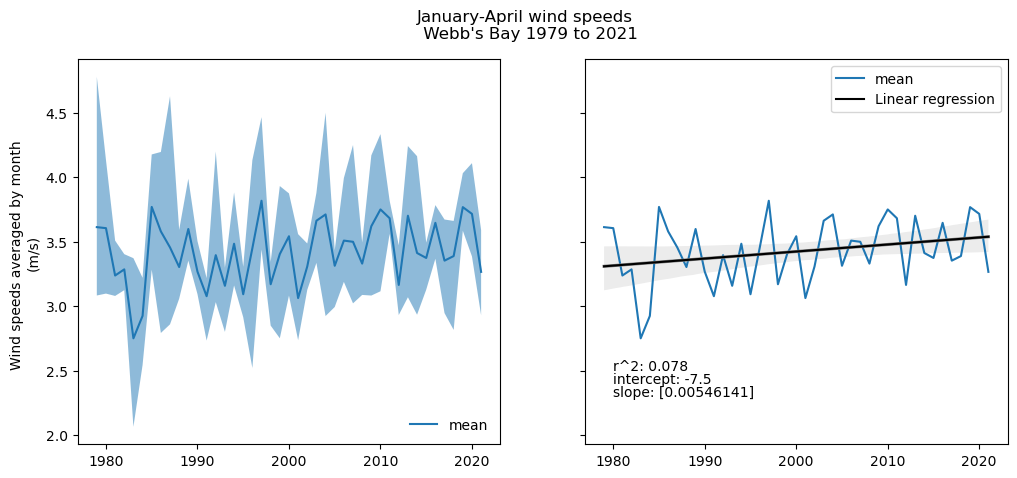

In [642]:
x = np.linspace(1979, 2021, 43)
y = winter.mean()
y1 = winter.max()
y2 = winter.min()

# plot
fig, (ax, ax2) = plt.subplots(1,2, figsize=(12,5), sharey=True)

ax.plot(x, y, label="mean")
ax.fill_between(x, y1, y2, alpha=.5, linewidth=0)
ax.set_ylabel("Wind speeds averaged by month \n(m/s)")
ax.legend(frameon=False, loc="lower right")

# 2nd plot showing trendline for mean data
ax2.plot(x, y, label="mean")
sns.regplot(x=x, y=y, marker='', color='grey')
fig.suptitle("January-April wind speeds \n Webb's Bay 1979 to 2021")

# linear regression
x = x.reshape((-1,1)) # reshape array
y = y.to_numpy() # change pd series to numpy array

new_model = LinearRegression().fit(x, y) 
r_sq = new_model.score(x, y) # calculate coefficient of determination
y_pred = new_model.intercept_ + new_model.coef_ * x # predicted y values

# add text to figure
ax2.text(x=1980, y=2.5, s=f"r^2: {r_sq:0.2}")
ax2.text(x=1980, y=2.4, s= f"intercept: {new_model.intercept_:0.3}")
ax2.text(x=1980, y=2.3, s=f"slope: {new_model.coef_}")

# plot model fit
ax2.plot(x, y_pred, color='black', label='Linear regression')

ax2.legend()

plt.show()

In [643]:
summer = ws.iloc[4:8, :] # May to August inclusive
summer

year,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
month,,,,,,,,,,,,,,,,,,,,,
5,2.648844,3.130508,2.962164,3.155551,2.721411,2.821638,2.583618,2.697243,3.475359,3.025625,...,2.483613,2.922292,2.433503,3.113914,2.827263,2.205675,3.531363,2.215330,3.309093,3.162012
6,2.987472,2.931574,2.857362,2.198636,3.064488,2.911437,2.913042,3.254279,2.964414,3.413650,...,2.175434,2.778092,2.755192,3.057715,3.053309,2.739990,2.974771,2.664731,2.643852,3.037248
7,3.066776,2.804458,3.625434,2.692630,3.170971,2.586381,2.623133,2.847379,2.909777,2.816070,...,2.516971,3.235049,2.916614,2.379230,3.016834,2.998528,2.974988,2.766899,2.845056,2.861596
8,3.065351,2.388775,2.446871,3.151660,2.986007,3.586902,2.490277,2.906412,2.393810,3.421101,...,2.433766,3.068559,2.441374,2.436682,2.888393,2.796335,3.310210,2.682798,2.943310,2.934356


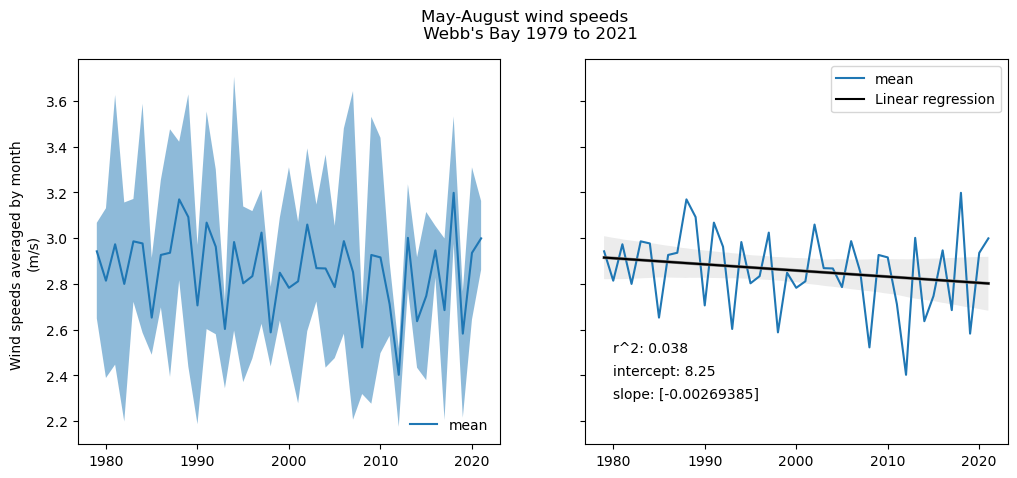

In [645]:
x = np.linspace(1979, 2021, 43)
y = summer.mean()
y1 = summer.max()
y2 = summer.min()

# plot
fig, (ax, ax2) = plt.subplots(1,2, figsize=(12,5), sharey=True)

ax.plot(x, y, label="mean")
ax.fill_between(x, y1, y2, alpha=.5, linewidth=0)
ax.set_ylabel("Wind speeds averaged by month \n(m/s)")
ax.legend(frameon=False, loc="lower right")

# 2nd plot showing trendline for mean data
ax2.plot(x, y, label="mean")
sns.regplot(x=x, y=y, marker='', color='grey')
fig.suptitle("May-August wind speeds \n Webb's Bay 1979 to 2021")

# linear regression
x = x.reshape((-1,1)) # reshape array
y = y.to_numpy() # change pd series to numpy array

new_model = LinearRegression().fit(x, y) 
r_sq = new_model.score(x, y) # calculate coefficient of determination
y_pred = new_model.intercept_ + new_model.coef_ * x # predicted y values

# add text to figure
ax2.text(x=1980, y=2.5, s=f"r^2: {r_sq:0.2}")
ax2.text(x=1980, y=2.4, s= f"intercept: {new_model.intercept_:0.3}")
ax2.text(x=1980, y=2.3, s=f"slope: {new_model.coef_}")

# plot model fit
ax2.plot(x, y_pred, color='black', label='Linear regression')

ax2.legend()

plt.show()

Fairly distinctive decrease in wind speed over time for the summer season. Coupled with reduced variability in the min/max

## Winter vs. Fall trends in wind speeds:

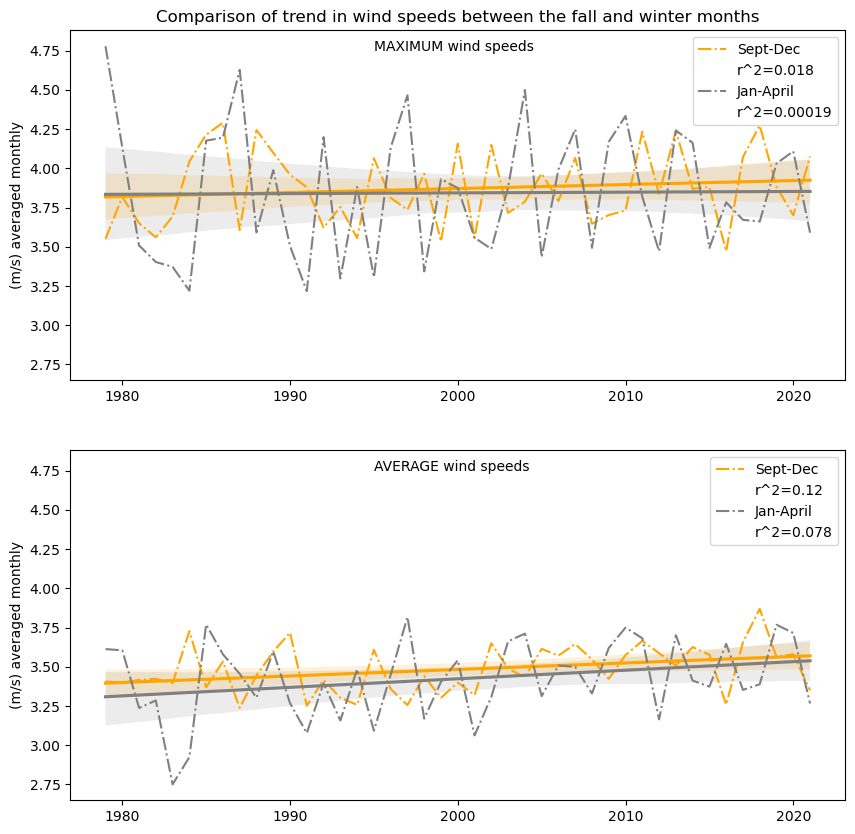

In [658]:
# plot
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10,10), sharey=True)

y1 = fall.max()
x = x.reshape((-1,1)) # reshape array

# linear regression FALL MAX WS
new_model = LinearRegression().fit(x, y1) 
r_sq = new_model.score(x, y1) # calculate coefficient of determination

# Sept-Dec MAX ws
ax.plot(x, y1, color='orange', linestyle='-.', label='Sept-Dec')
sns.regplot(x=x, y=y1,  marker='', color='orange', ax=ax, label=f"r^2={r_sq:0.2}")

# ------------------------------------------------------------------------------------------------------------

y2 = winter.max()

# linear regression WINTER MAX WS
new_model = LinearRegression().fit(x, y2) 
r_sq = new_model.score(x, y2) # calculate coefficient of determination

# Jan-April MAX ws
ax.plot(x, y2, color='grey', linestyle='-.', label='Jan-April')
sns.regplot(x=x, y=y2, marker='', color='grey', ax=ax, label=f"r^2={r_sq:0.2}")

ax.set_ylabel('(m/s) averaged monthly')
ax.text(x=1995, y=4.75,s='MAXIMUM wind speeds')
ax.legend()

# ------------------------------------------------------------------------------------------------------------

y3 = fall.mean()

# linear regression FALL MEAN WS
new_model = LinearRegression().fit(x, y3) 
r_sq = new_model.score(x, y3) # calculate coefficient of determination

# Sept-Dec MEAN ws
ax2.plot(x, y3, color='orange', linestyle='-.', label='Sept-Dec')
sns.regplot(x=x, y=y3,  marker='', color='orange', label=f"r^2={r_sq:0.2}")

# ------------------------------------------------------------------------------------------------------------

y4 = winter.mean()

# linear regression WINTER MEAN WS
new_model = LinearRegression().fit(x, y4) 
r_sq = new_model.score(x, y4) # calculate coefficient of determination

# Jan-April MEAN ws
ax2.plot(x, y4, color='grey', linestyle='-.', label='Jan-April')
sns.regplot(x=x, y=y4, marker='', color='grey', label=f"r^2={r_sq:0.2}")

ax2.set_ylabel('(m/s) averaged monthly')
ax2.text(x=1995, y=4.75,s='AVERAGE wind speeds')
ax2.legend()

ax.set_title('Comparison of trend in wind speeds between the fall and winter months')

plt.show()

## Wind speed anomalies:

Climatology calculated as averages for the period between 1981-2010

In [659]:
# note: returning to xarray dataset  
# already resampled to monthly averages and a single point location

clim_ds = monthly_avg.sel(time=slice('1981-01-01', '2010-01-01')).groupby('time.month').mean('time')
clim_ds

<xarray.Dataset>
Dimensions:    (month: 12)
Coordinates:
    longitude  float32 298.2
    latitude   float32 56.75
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    u10        (month) float32 2.269 2.115 1.47 0.8214 ... 1.381 2.018 2.32
    v10        (month) float32 -0.9443 -0.9538 -1.258 ... -0.4495 -0.8039
    speed      (month) float32 3.531 3.385 3.415 3.173 ... 3.268 3.394 3.52 3.63
    direction  (month) float32 285.1 286.5 293.1 288.3 ... 273.3 274.8 283.0

Anomalies calculated by subtracting the "climatology" values

In [660]:
anom_ds = monthly_avg.groupby('time.month') - clim_ds
anom_ds

<xarray.Dataset>
Dimensions:    (time: 516)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    longitude  float32 298.2
    latitude   float32 56.75
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    u10        (time) float32 -0.7808 0.7739 0.03966 ... -0.7043 -0.883 -0.04876
    v10        (time) float32 0.3181 -1.664 0.5373 ... -0.356 0.2357 -0.3647
    speed      (time) float32 -0.2176 1.394 -0.3325 ... -0.6389 -0.2959 0.4447
    direction  (time) float32 7.223 15.84 -6.123 3.454 ... 17.75 -3.206 5.306

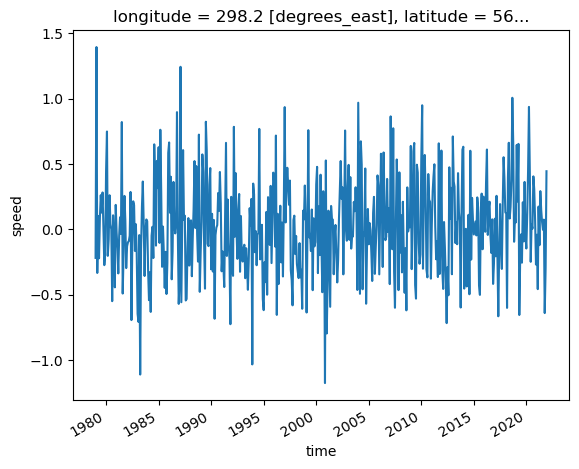

In [661]:
anom_ds["speed"].plot()

In [662]:
# create a pandas dataframe of wind speed anomalies

ws_anom = anom_ds["speed"].reset_coords(drop=True).to_dataframe()

# add year and month indices
ws_anom['month']=ws_anom.index.month
ws_anom['year']=ws_anom.index.year

# groupby month and year and mean
ws_anom = ws_anom.groupby(['year','month']).mean().unstack().T.droplevel(0)
ws_anom.head()

year,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
month,,,,,,,,,,,,,,,,,,,,,
1,-0.217550,0.444148,-0.022915,-0.128038,-0.645080,-0.311381,0.628520,0.664639,-0.375382,0.060509,...,-0.308495,0.710540,0.631805,-0.038434,0.131350,0.082028,0.129839,0.053737,-0.145523,-0.040378
2,1.393641,0.748244,-0.149180,-0.097660,-0.706611,-0.540133,-0.102940,0.127521,1.242712,0.069420,...,-0.454431,0.366255,-0.452086,0.013723,-0.017894,-0.205290,0.122903,0.645626,0.120920,-0.456089
3,-0.332549,-0.201724,-0.336002,-0.089280,-0.043100,-0.326599,0.761595,0.402591,-0.556217,-0.357590,...,0.056658,0.327977,-0.040800,0.060060,0.356028,0.256785,-0.599439,0.213653,0.446038,0.174882
4,0.102793,-0.075621,-0.046276,-0.049092,-1.108816,-0.630183,0.286677,-0.381021,0.005576,-0.063796,...,-0.140413,-0.104122,0.004702,-0.045553,0.610644,-0.226866,0.395877,0.653800,0.936120,-0.120226
5,-0.220362,0.261302,0.092958,0.286345,-0.147795,-0.047569,-0.285589,-0.171964,0.606153,0.156418,...,-0.385593,0.053085,-0.435704,0.244708,-0.041944,-0.663531,0.662156,-0.653876,0.439886,0.292806


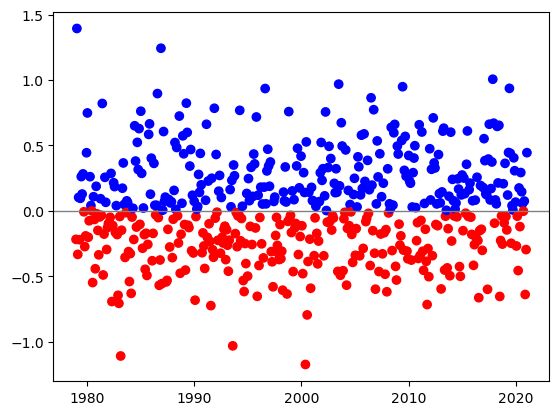

In [663]:
x = np.linspace(1979, 2021, 516)
y = anom_ds["speed"]
c = np.where(anom_ds["speed"]>0, "blue", "red")

fig, ax = plt.subplots()

ax.scatter(x,y,c=c)
ax.axhline(0, color='grey', linewidth=1)

plt.show()

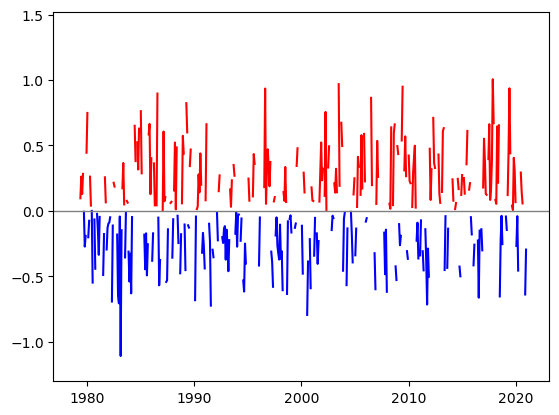

In [671]:
fig, ax = plt.subplots()

pos_signal = anom_ds["speed"].copy() 
neg_signal = anom_ds["speed"].copy()

pos_signal[pos_signal <= 0] = np.nan
neg_signal[neg_signal > 0] = np.nan

ax.plot(x, pos_signal, color='r')
ax.plot(x, neg_signal, color='b')
ax.axhline(0, color='grey', linewidth=1)

plt.show()

## Frequency of high wind events:

"High winds" defined as any positive wind anomaly

In [686]:
pos_signal.count()

<xarray.DataArray 'speed' ()>
array(262)
Coordinates:
    longitude  float32 298.2
    latitude   float32 56.75

In [687]:
# pd Dataframe of positive wind speed anomalies

pos_signal[pos_signal >= 0] = 1 # changing anomaly values to 1
pos_wa = pos_signal.reset_coords(drop=True).to_dataframe()

# add year and month indices
pos_wa['month']=pos_wa.index.month
pos_wa['year']=pos_wa.index.year

# groupby month and year and mean
pos_wa = pos_wa.groupby(['year','month']).mean().unstack().T.droplevel(0)
pos_wa.head() # display first few lines of the Dataframe

year,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
month,,,,,,,,,,,,,,,,,,,,,
1,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,...,NaN,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN
2,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,...,NaN,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,1.0,1.0,NaN,1.0,1.0,1.0,NaN,1.0,1.0,1.0
4,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,...,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0,1.0,NaN
5,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,1.0


## Frequency of high winds during fall season:

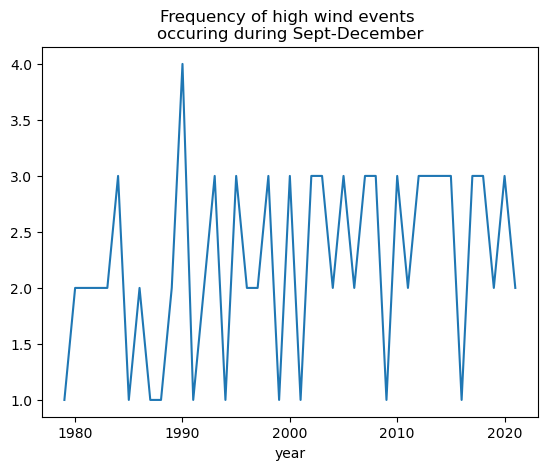

In [720]:
fall_wa = pos_wa.iloc[8:12, :] # September to December inclusive
fall_wa.sum().plot() # sum & plot
plt.title('Frequency of high wind events \noccuring during Sept-December')
plt.show()

## Frequency of high winds during winter season:

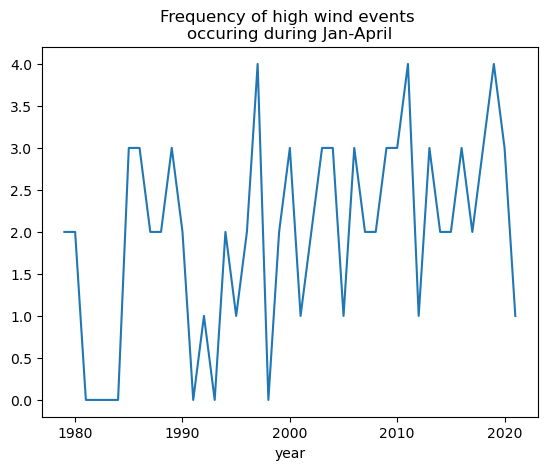

In [721]:
fall_wa = pos_wa.iloc[0:4, :] # January to April inclusive
fall_wa.sum().plot() # sum & plot
plt.title('Frequency of high wind events \noccuring during Jan-April')
plt.show()

### next steps :

(1) better visualization for frequency plots?

(2) high winds from the east

In [159]:
# create a pandas dataframe of wind DIRECTION values
# pd dfs support double reindexing but xarray will only reindex once

wdir = monthly_avg["direction"].reset_coords(drop=True).to_dataframe()

# add year and month indices
wdir['month']=wdir.index.month
wdir['year']=wdir.index.year

# groupby month and year and mean
wdir = wdir.groupby(['year','month']).mean().unstack().T.droplevel(0)

# groupby function creates groupby object
# mean, unstack, transpose, and drop level  stack rows 
# ref https://stackoverflow.com/questions/64319937/plot-monthly-average-over-multiple-years-with-xarray

In [160]:
wdir.head()

year,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
month,,,,,,,,,,,,,,,,,,,,,
1,292.344452,297.704681,292.462402,279.597198,282.629120,267.613708,317.378204,280.286072,281.451080,279.879486,...,284.677826,280.887970,274.374817,275.902374,286.265564,289.549011,291.105804,280.716522,281.288635,294.755432
2,302.314270,312.126556,259.460876,278.961121,281.509766,299.390076,300.592773,286.147125,320.588165,256.050964,...,290.637482,306.233582,291.982422,288.577423,282.590179,291.188232,267.682953,301.948792,281.542542,304.168793
3,286.981781,287.681885,330.790436,270.551147,305.198700,312.366577,294.240143,273.490326,302.776367,298.176147,...,286.897491,321.866516,297.506195,292.053497,289.038849,303.142487,289.193665,269.925476,284.246857,288.701752
4,291.721008,264.653900,315.874603,288.537964,269.480438,264.393433,300.470093,282.604675,265.221832,261.193237,...,296.487762,286.023529,292.519653,279.250397,290.257843,271.227173,298.004944,284.742462,296.335907,312.835632
5,283.914978,312.074585,272.169647,288.218567,266.021301,299.183014,300.062531,290.767944,263.165283,258.811188,...,253.184692,289.094543,286.052216,265.834045,282.311066,270.404022,271.088837,298.280151,307.330139,306.195801


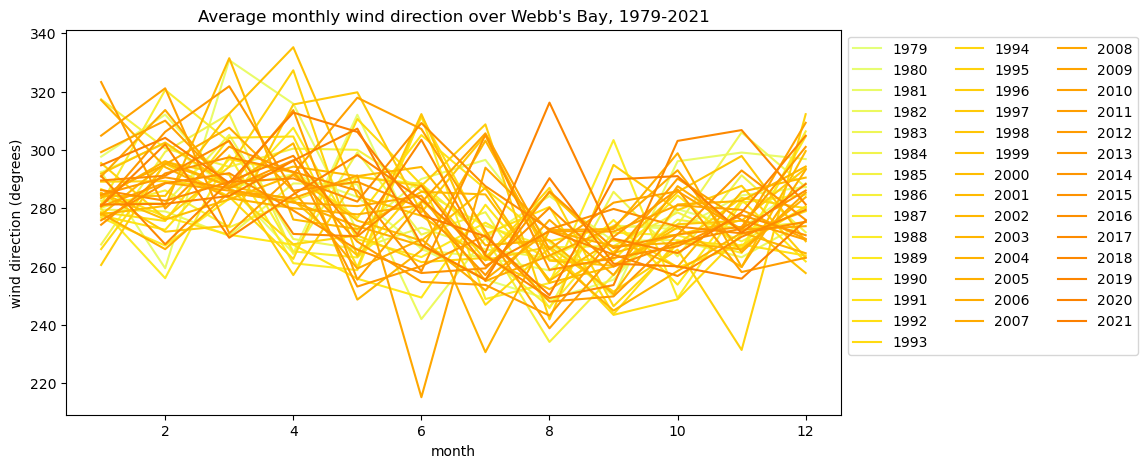

In [165]:
# Visualize the wind direction time series

wdir.plot(figsize=(10,5), cmap="Wistia", ylabel="wind direction (degrees)",
       title="Average monthly wind direction over Webb's Bay, 1979-2021")

plt.legend(ncol=3, bbox_to_anchor=[1,1])
plt.show()